<a href="https://colab.research.google.com/github/PabloParadaSouto/Automatica/blob/master/ACTOR-CRITIC-KERAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import gym
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
!apt install xvfb -y
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
from IPython import display



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

KeyboardInterrupt: 

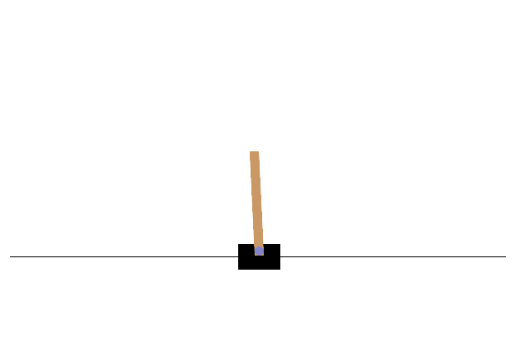

In [10]:
# Función de pérdida personalizada para el crítico
def custom_loss(y_true, y_pred):
    # y_true son las ventajas
    # y_pred son los valores de salida del crítico
    return -K.mean(y_true * y_pred)

# Definición del modelo del actor
def build_actor(input_shape, output_shape, learning_rate):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    output_layer = Dense(output_shape, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    return model

# Definición del modelo del crítico
def build_critic(input_shape, learning_rate):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    output_layer = Dense(1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=custom_loss)
    return model

# Definición del agente Actor-Critic
class ActorCriticAgent:
    def __init__(self, input_shape, action_space, actor_lr=0.001, critic_lr=0.005, gamma=0.99):
        self.action_space = action_space
        self.gamma = gamma

        # Construyendo el modelo del actor
        self.actor = build_actor(input_shape, action_space, actor_lr)

        # Construyendo el modelo del crítico
        self.critic = build_critic(input_shape, critic_lr)

    def act(self, state):
        # Predecir las probabilidades de las acciones
        probabilities = self.actor.predict(np.expand_dims(state, axis=0))[0]
        action = np.random.choice(self.action_space, p=probabilities)
        #action = np.argmax(probabilities)
        return action

    def train(self, states, actions, rewards, next_states, dones):
        # Calculando las ventajas
        values = self.critic.predict(states)
        next_values = self.critic.predict(next_states)
        advantages = rewards + (1 - dones) * self.gamma * next_values - values

        # Entrenando el crítico
        self.critic.fit(states, rewards, verbose=0)

        # Entrenando el actor
        actions_one_hot = np.eye(self.action_space)[actions]
        self.actor.fit(states, actions_one_hot * advantages, verbose=0)

# Entrenamiento del agente
env = gym.make('CartPole-v1')
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

d = Display()
d.start()

agent = ActorCriticAgent(input_shape=(state_space,), action_space=action_space)

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(np.array([state]), np.array([action]), np.array([reward]), np.array([next_state]), np.array([done]))
        total_reward += reward
        state = next_state

        img = plt.imshow(env.render('rgb_array'))

        display.clear_output(wait=True)
        img.set_data(env.render('rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())

        print("EPISODIO: ", episode)
        print("ACCION: ", action)

    # Imprimir información del episodio
    actor_loss = agent.actor.history.history['loss'][0]  # Pérdida del actor
    critic_loss = agent.critic.history.history['loss'][0]  # Pérdida del crítico
    actor_values = agent.actor.predict(np.array([state]))[0]  # Valores de salida del actor
    critic_value = agent.critic.predict(np.array([state]))[0]  # Valor de salida del crítico


    print(f"Episode: {episode}, Total Reward: {total_reward}")
    print("Actor loss: ", actor_loss)
    print("Critic loss: ", critic_loss)
    #print("Actor output: ", actor_values)
    #print("Critic output: ", critic_value)

env.close()